In [72]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import random
import tensorflow as tf
import numpy as np
import os

In [75]:
def make_result_reproducible(seed_value):

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    # import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    # import random
    random.seed(seed_value)

    # For numpy
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # import tensorflow as tf
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)



def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    print(end_date)
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    print(df['time_bin'].dtype)
    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 
    grid_crime_df['x_index'] = grid_crime_df['x_index'].astype('int64') 
    grid_crime_df['y_index'] = grid_crime_df['y_index'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D') # doesn't allow for custom bins
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)
    grid_crime_df['day_of_week'] = grid_crime_df['occ_date'].dt.dayofweek

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'x_index', 'y_index', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences



def calculate_neighbourhood_crime_counts(data, radius=10):
  
    # Ensure data is sorted for efficient processing
    data = data.sort_values(by="time_bin")

    # Prepare results
    results = []

    # Process each time_bin
    for time_bin, group in data.groupby("time_bin"):
        group_results = []
        
        # Convert group to a dictionary for efficient lookup
        crime_lookup = {(row.x_index, row.y_index): row.crime_count for row in group.itertuples()}
        
        # Iterate through each cell
        for _, row in group.iterrows():
            x, y = row["x_index"], row["y_index"]
            
            # Neighborhood bounds
            x_min, x_max = x - radius, x + radius
            y_min, y_max = y - radius, y + radius
            
            # Calculate total crimes in the neighborhood
            total_neighborhood_crime = sum(
                crime_lookup.get((i, j), 0)
                for i in range(x_min, x_max + 1)
                for j in range(y_min, y_max + 1)
            )
            
            # Append result for this cell
            group_results.append({
                "unique_id": row["unique_id"],
                "time_bin": row["time_bin"],
                "neighbourhood_crime_count": total_neighborhood_crime,
            })
        
        # Extend results
        results.extend(group_results)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge results back to the original data
    data = data.merge(results_df, on=["unique_id", "time_bin"])
    
    return data



In [76]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")
cell_size = 600
aggregation_period = 14 # In days
seed_value = 1
make_result_reproducible(seed_value)

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

combined_crime_counts_df = pd.concat([train_crime_counts_df, test_crime_counts_df])

threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)
hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)


sequence_length = 26 # looking over whole year data to capture seasonal trend


2017-03-14 00:00:00
datetime64[ns]
2017-06-14 00:00:00
datetime64[ns]
5.0


/tmp/ipykernel_175948/2042492305.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_175948/2042492305.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [77]:
# run only once
last_time_bin = train_hotspots_crime_counts_df.time_bin.max()
start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])

#Ensuring all the same cells in both train and test data
# np.all(hotspot_cells == np.sort(test_hotspots_crime_counts_df.unique_id.unique()) )

test_hotspots_crime_counts_df.unique_id.unique().size
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,hotspot
839,1290,33,96,2016-03-10,1,0
840,1290,33,96,2016-03-24,2,0
841,1290,33,96,2016-04-07,1,0
842,1290,33,96,2016-04-21,2,0
843,1290,33,96,2016-05-05,2,0
...,...,...,...,...,...,...
6353,11781,148,34,2017-05-24,1,0
6369,11822,149,34,2017-03-29,1,0
6370,11822,149,34,2017-04-12,2,0
6371,11822,149,34,2017-04-26,3,0


In [78]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_current = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bins_history.append(test_time_bins_current)

In [ ]:

all_train_cells = train_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()
all_test_cells = test_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()

# all_train_cells_dict  = train_crime_counts_df.set_index(['unique_id', 'x_index', 'y_index']).T.to_dict() # just a bit faster
# train_time_bins_df = pd.DataFrame([(unique_id, x_index, y_index, time_bin) for unique_id, x_index, y_index in all_train_cells_dict for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# train_time_bins_df
train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
test_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in test_time_bins.sort_values()],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])

# # train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for index, row in train_crime_counts_df.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# # test_time_bins_df = pd.DataFrame([(unique_id, time_bin) for unique_id in all_test_cells for time_bin in test_time_bins],columns=['unique_id', 'time_bin'])

# train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
# # test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df, on=[ 'unique_id'], how='left').fillna(0)


In [80]:
train_hotspots_crime_counts_df[train_hotspots_crime_counts_df['unique_id'].isin(hotspot_cells)].unique_id.unique().size

351

In [81]:
test_time_bins_df[test_time_bins_df.unique_id.isin(hotspot_cells)].unique_id.unique().size
# hotspot_cells

351

In [82]:
test_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count
0,91,9,97,2017-05-24,1
1,456,21,103,2017-03-01,1
2,456,21,103,2017-05-24,1
3,457,21,104,2017-05-10,1
4,482,22,66,2017-05-10,1
...,...,...,...,...,...
6384,11837,149,49,2017-04-26,1
6385,11837,149,49,2017-05-24,2
6386,11865,150,70,2017-03-01,1
6387,11887,151,71,2017-03-01,1


In [ ]:
test_crime_counts_df_with_history = combined_crime_counts_df[combined_crime_counts_df['time_bin']>=start_time_bin_test_data_dependends_upon]
train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df_with_history, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
train_crime_counts_df_with_all_time_bins['crime_count'].max()
test_crime_counts_df_with_all_time_bins['crime_count'].max()

,unique_id,x_index,y_index,time_bin,crime_count
5874,1290,33,96,2016-03-10,1.0
5875,1290,33,96,2016-03-24,2.0
5876,1290,33,96,2016-04-07,1.0
5877,1290,33,96,2016-04-21,2.0
5878,1290,33,96,2016-05-05,2.0
5879,1290,33,96,2016-05-19,0.0
5880,1290,33,96,2016-06-02,1.0
5881,1290,33,96,2016-06-16,0.0
5882,1290,33,96,2016-06-30,1.0
5883,1290,33,96,2016-07-14,2.0


In [89]:

# train_hotspots_crime_counts_df["neighbourhood_crime_counts"] = train_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(train_crime_counts_df_with_all_time_bins, 1 )
# )

train_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts(train_crime_counts_df_with_all_time_bins, radius=5)
test_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts(test_crime_counts_df_with_all_time_bins, radius=5)
# x = calculate_neighbourhood_crime_counts(train_hotspots_crime_counts_df, radius=1)

# test_hotspots_crime_counts_df["neighbourhood_crime_counts"] = test_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(test_crime_counts_df_with_all_time_bins, 10 )
# )



In [90]:
train_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
train_hotspots_crime_counts_df.loc[train_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
test_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
test_hotspots_crime_counts_df.loc[test_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
train_hotspots_crime_counts_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]

In [ ]:

train_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates',str(cell_size),  f'train_hotspots_crime_counts_df_{threshold}_{sequence_length}.csv'))
test_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates', str(cell_size), f'test_hotspots_crime_counts_df_{threshold}_{sequence_length}.csv'))


In [ ]:
train_hotspots_crime_counts_df = train_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1775,1290,33,96,2016-03-10,1.0,21.0,0
13321,1290,33,96,2016-03-24,2.0,24.0,0
14769,1290,33,96,2016-04-07,1.0,31.0,0
25480,1290,33,96,2016-04-21,2.0,28.0,0
30441,1290,33,96,2016-05-05,2.0,20.0,0
...,...,...,...,...,...,...,...
196301,11822,149,34,2017-03-29,1.0,18.0,0
207940,11822,149,34,2017-04-12,2.0,15.0,0
210688,11822,149,34,2017-04-26,3.0,14.0,0
217164,11822,149,34,2017-05-10,0.0,16.0,0


In [93]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

In [94]:
train_hotspots_crime_counts_df
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1775,1290,33,96,2016-03-10,1.0,21.0,0
13321,1290,33,96,2016-03-24,2.0,24.0,0
14769,1290,33,96,2016-04-07,1.0,31.0,0
25480,1290,33,96,2016-04-21,2.0,28.0,0
30441,1290,33,96,2016-05-05,2.0,20.0,0
...,...,...,...,...,...,...,...
196301,11822,149,34,2017-03-29,1.0,18.0,0
207940,11822,149,34,2017-04-12,2.0,15.0,0
210688,11822,149,34,2017-04-26,3.0,14.0,0
217164,11822,149,34,2017-05-10,0.0,16.0,0


In [95]:
training_sequences = create_sequences(train_hotspots_crime_counts_df, seq_length=sequence_length)


In [96]:
training_sequences[0]

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1576,1290,33,96,2012-03-01,1.0,27.0,0
9636,1290,33,96,2012-03-15,0.0,17.0,0
15322,1290,33,96,2012-03-29,1.0,11.0,0
27226,1290,33,96,2012-04-12,0.0,17.0,0
33326,1290,33,96,2012-04-26,0.0,16.0,0
35954,1290,33,96,2012-05-10,3.0,21.0,0
47324,1290,33,96,2012-05-24,3.0,19.0,0
54461,1290,33,96,2012-06-07,0.0,15.0,0
62473,1290,33,96,2012-06-21,0.0,21.0,0
66107,1290,33,96,2012-07-05,1.0,27.0,0


In [97]:
testing_sequences = create_sequences(test_hotspots_crime_counts_df, seq_length=sequence_length)

In [98]:
testing_sequences[0]

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1775,1290,33,96,2016-03-10,1.0,21.0,0
13321,1290,33,96,2016-03-24,2.0,24.0,0
14769,1290,33,96,2016-04-07,1.0,31.0,0
25480,1290,33,96,2016-04-21,2.0,28.0,0
30441,1290,33,96,2016-05-05,2.0,20.0,0
39656,1290,33,96,2016-05-19,0.0,20.0,0
42820,1290,33,96,2016-06-02,1.0,31.0,0
54087,1290,33,96,2016-06-16,0.0,23.0,0
62356,1290,33,96,2016-06-30,1.0,26.0,0
68811,1290,33,96,2016-07-14,2.0,19.0,0


In [99]:
from sklearn.utils import resample

positive_data = []
negative_data = []
for sequence in training_sequences:
    if sequence['hotspot'].iloc[-1] == 1:
        positive_data.append(sequence)
    else:
        negative_data.append(sequence)

print(len(positive_data))
negative_data = resample(negative_data, replace=False,  n_samples=len(positive_data), random_state=1) 

# Combine positive and negative data
balanced_data = positive_data + negative_data

from sklearn.model_selection import train_test_split


# Split into training and remaining sets
train_data, val_data = train_test_split(balanced_data, test_size=0.1, random_state=1)

test_data = testing_sequences
# # Split the remaining set into validation and test sets
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=1)

2248


In [ ]:


def prepare_trainable_data(samples):
    X = []
    y = []
    for seq in samples:
        X_seq = seq[['neighbourhood_crime_count']].values  # Select features for X
        X.append(X_seq[:-1])  # Exclude the last time step from X
        y.append(seq['hotspot'].iloc[-1])  # Use the last time step's 'hotspot' value as y
    # return X, y
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_trainable_data(train_data)

# Prepare validation data
X_val, y_val = prepare_trainable_data(val_data)

# Prepare test data
X_test, y_test = prepare_trainable_data(test_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((4046, 26, 1), (2457, 26, 1), (4046,), (2457,))

In [ ]:
make_result_reproducible(seed_value)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate= 0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [125]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.5491 - loss: 0.6802 - val_accuracy: 0.7111 - val_loss: 0.6031
Epoch 2/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.7249 - loss: 0.5905 - val_accuracy: 0.7067 - val_loss: 0.5876
Epoch 3/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.7248 - loss: 0.5659 - val_accuracy: 0.7089 - val_loss: 0.5847
Epoch 4/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.7280 - loss: 0.5585 - val_accuracy: 0.7111 - val_loss: 0.5834
Epoch 5/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.7299 - loss: 0.5551 - val_accuracy: 0.7111 - val_loss: 0.5825
Epoch 6/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.7289 - loss: 0.5531 - val_accuracy: 0.7133 - val_loss: 0.5818
Epoch 7/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.7308 - loss: 0.5518 - val_accuracy: 0.7200 - val_loss: 0.5812
Epoch 8/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.7296 - loss: 0

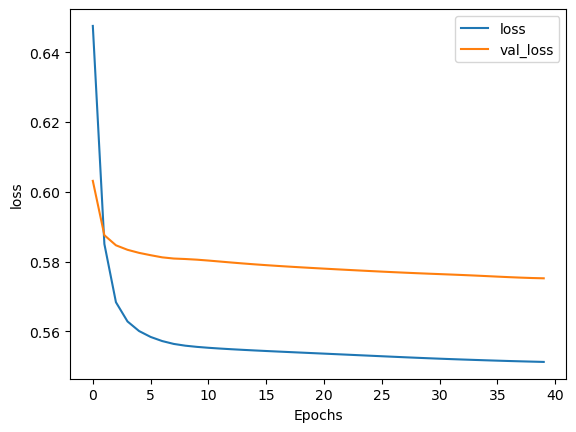

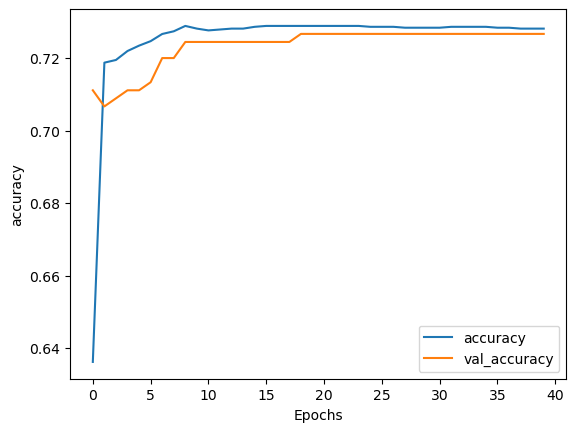

In [126]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
# plot_history(history, 'precision')
# plot_history(history, 'recall')


In [127]:
X_test
test = np.load('a.npy')
np.all(X_test == test)

False

In [128]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the test data
# _, accuracy = model.evaluate(X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
# print(metrics)
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7720 - loss: 0.5992
Accuracy: 84.25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Precision: 23.45
Recall: 65.38
F1-score: 34.52


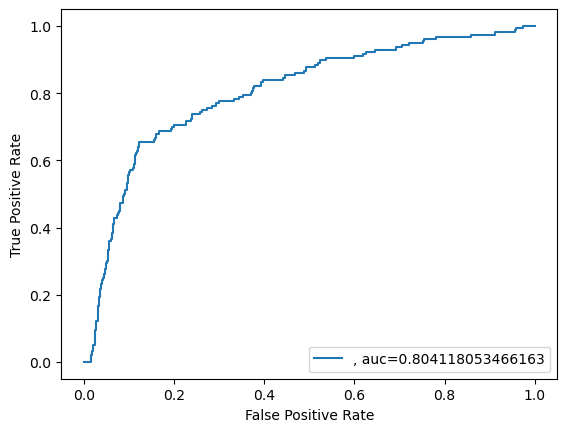

In [129]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label=", auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# test_data.shape
# X_test.shape, len(test_data)
# import datetime
# x = pd.concat(test_data)
# y = []
# for i in range(1,len(hotspot_cells)):
#     y.append(x['hotspot'].iloc[24*i])

# # test_data[6]
# x[x.time_bin.dt.date == datetime.date(2017,3,1)].drop_duplicates()

In [115]:
import datetime
crime_hotspots = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.time_bin.dt.date >= datetime.date(2017, 3, 1) ]


crime_hotspots.loc[:,'predicted'] = y_pred_binary
# predicted_cell_ids = np.array(crime_hotspots[(crime_hotspots['predicted'] == 1) & (crime_hotspots.time_bin.dt.date == datetime.date(2017, 3, 1))]['unique_id'])
# actual_cell_ids = np.array(crime_hotspots[(crime_hotspots['hotspot'] == 1) & (crime_hotspots.time_bin.dt.date == datetime.date(2017, 3, 1)) ]['unique_id'])
# # real = crime_hotspots.hotspot
# # pred = crime_hotspots.predicted
# com = np.intersect1d(predicted_cell_ids, actual_cell_ids)

# test_hotspots_crime_counts_df
crime_hotspots['predicted'].sum()
y_pred_binary.sum()

/tmp/ipykernel_175948/4262149700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_hotspots.loc[:,'predicted'] = y_pred_binary


457

In [116]:
cell_size = 600
# ppd_grids_clipped = gpd.read_file(f"../Qgis/self-created-grid/{cell_size}/crime-forecast-grid.shp")
grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

In [117]:
test_time_step_starting_dates = test_time_bins[-7:]
test_time_step_starting_dates
crime_hotspots_1st_week = crime_hotspots[crime_hotspots.time_bin.dt.date == test_time_step_starting_dates[0].date() ]
crime_hotspots_1st_week['predicted'].sum()
predicted_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].unique_id)
hotspot_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['hotspot'] == 1].unique_id)


total_crimes_in_predicted_hotspots = crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count.sum()


predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()

# # x

In [118]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
# maximum_obtainable_crimes_for_the_forecasted_area = 
# 
total_area, predicted_hotspots_area / (cell_size ** 2), pai
# pai


201.0
1381
23400000.0
4117743414.8055296


(4117743414.8055296, 65.0, 25.61213620675936)

In [ ]:

grid[grid.unique_id.isin(hotspot_grid_ids)]
desc_sorted = -np.sort(-np.array(crime_hotspots_1st_week.crime_count))

number_of_cells = int(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted[:number_of_cells].sum()

pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
pei

# grid['pre']
    
# # y_test
# test_crime_counts_df.crime_count.max()

In [ ]:
len(predicted_grid_ids), len(hotspot_grid_ids), len(np.intersect1d(predicted_grid_ids, hotspot_grid_ids))

In [ ]:
grid.loc[grid.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(hotspot_grid_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(predicted_grid_ids, hotspot_grid_ids)), 'hotspot'] = 3
grid.to_file(f"../Qgis/outputs/{cell_size}/crime-forecast-grid-new-26.shp")
grid
